In [0]:
 !pip install stable-baselines==2.9.0

     |████████████████████████████████| 235kB 25.3MB/s 
  Found existing installation: stable-baselines 2.2.1
    Uninstalling stable-baselines-2.2.1:
      Successfully uninstalled stable-baselines-2.2.1


In [0]:
import numpy as np

import datetime
import time
from collections import deque

import torch as T
import torch.nn as nn
from torch.autograd import Variable
from torch.optim import Adam
from torch.distributions import Categorical
from torch.optim.lr_scheduler import LambdaLR
from torchsummary import summary

from stable_baselines.common.misc_util import set_global_seeds
from stable_baselines.common.cmd_util import make_atari_env
from stable_baselines.common.vec_env import VecFrameStack

import matplotlib.pyplot as plt
import seaborn as sns

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [0]:
ENV_NAME = 'BreakoutNoFrameskip-v4'
NENV = 8
ROLLOUT_LENGTH = 128
LATENT_SIZE = 64
MB_SPLIT = 4
MB_EPOCHS = 4
TOTAL_TIMESTEPS = 5e6
GAMMA = 0.99
CLIP = 0.2
DEVICE = T.device('cuda' if T.cuda.is_available() else 'cpu')
SEED = 420 
set_global_seeds(SEED)
sns.set()  # make it pretty

# Environment

In [0]:
env = make_atari_env(ENV_NAME, num_env=NENV, seed=SEED)
env = VecFrameStack(env, n_stack=4)

in_dim = env.observation_space.shape
in_dim=(in_dim[2],in_dim[0],in_dim[1])  # torch ordering
num_actions = env.action_space.n

print('Observation shape: ', in_dim)
print('Number of actions: ', num_actions)

Observation shape:  (4, 84, 84)
Number of actions:  4


# CNNs

In [0]:
def conv_size(net, in_shape):
    """ util for calculating flat output shape of a given net """
    x = Variable(T.rand(1, *in_shape))
    o = net(x)
    b = (-1, o.size(1), o.size(2), o.size(3))
    return b, o.data.view(1, -1).size(1)

In [0]:
def ConvReLU_down(in_channels, out_channels, kernel, stride):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel, stride),
        nn.ReLU(inplace=True),
    )

def ConvReLU_up(in_channels, out_channels, kernel, stride):
    return nn.Sequential(
        nn.ConvTranspose2d(in_channels, out_channels, kernel, stride),
        nn.ReLU(inplace=True)
    )

class UNet(nn.Module):
    """ This is used to *represent* the environment (perception).
        The latent space of this autoencoder is uni-dimensional.
    """
    def __init__(self, input_shape, num_actions, latent_size):
        super().__init__()
        self.c, self.h, self.w = input_shape
        self.num_actions = num_actions
        self.latent_size = latent_size

        # this is to get the correct output size, because num_actions is
        # injected in forward pass.
        sizenet = nn.Sequential(
            ConvReLU_down(self.c+self.num_actions, 64+self.num_actions, 8, 4),
            ConvReLU_down(64+self.num_actions, 32+self.num_actions, 4, 2),
            ConvReLU_down(32+self.num_actions, 16+self.num_actions, 4, 1)
        )
        mod_in = (input_shape[0]+num_actions, input_shape[1], input_shape[2])
        self.conv_x, self.conv_f = conv_size(sizenet, mod_in)

        self.down_1 = ConvReLU_down(self.c+self.num_actions, 64, 8, 4)
        self.down_2 = ConvReLU_down(64+self.num_actions, 32, 4, 2)
        self.down_3 = ConvReLU_down(32+self.num_actions, 16, 4, 1)

        self.down_linear = nn.Sequential(
            nn.Flatten(),
            nn.Linear(self.conv_f, self.latent_size)
        )

        self.up_linear = nn.Sequential(
            nn.Linear(self.latent_size, self.conv_f),
            nn.ReLU(True)
        )

        self.up_3 = ConvReLU_up(16*2+self.num_actions*2, 32, 4, 1)
        self.up_2 = ConvReLU_up(32*2+self.num_actions, 64, 4, 2)
        self.up_1 = nn.ConvTranspose2d(64*2+self.num_actions, 1, 8, 4)

    def encode(self, x):
        z_action = self.one_hot_3d_action([0]*x.size(0), self.h, self.w)
        x = T.cat((x, z_action), dim=1)
        """ *represent* the environment in latent space"""
        x = self.down_1(x)
        x = self.down_2(x)
        x = self.down_3(x)
        x = self.down_linear(x)
        return x  # latent code

    def one_hot_3d_action(self, actions, h, w):
        z = np.zeros((len(actions), self.num_actions, h, w), dtype=np.float32)
        for i in range(len(actions)):
            z[i,actions[i],:,:] = 1.0
        z = T.from_numpy(z).to(DEVICE)
        return z

    def forward(self, x, actions=None):
        """ actions is a list of ints describing the actions taken """

        # add information about which action we took
        if actions is None: # for torchsummary
            actions = [0]*x.size(0)
  
        d0_action = self.one_hot_3d_action(actions, self.h, self.w)
        d0 = T.cat((x, d0_action), dim=1)

        d1 = self.down_1(d0)
        d1_h = d1.size(2)
        d1_w = d1.size(3)
        d1_action = self.one_hot_3d_action(actions, d1_h, d1_w)
        # inject information about which action we took
        d1 = T.cat((d1, d1_action), dim=1)

        d2 = self.down_2(d1)
        d2_h = d2.size(2)
        d2_w = d2.size(3)
        d2_action = self.one_hot_3d_action(actions, d2_h, d2_w)
        # inject information about which action we took
        d2 = T.cat((d2, d2_action), dim=1)

        d3 = self.down_3(d2)
        d3_h = d3.size(2)
        d3_w = d3.size(3)
        d3_action = self.one_hot_3d_action(actions, d3_h, d3_w)
        # inject information about which action we took
        d3 = T.cat((d3, d3_action), dim=1)

        latent = self.down_linear(d3)
        
        x = self.up_linear(latent)        
        x = x.view(self.conv_x)
        # cat contractive path (skip connections)
        x = T.cat((x, d3), dim=1)
        x = self.up_3(x)
        x = T.cat((x, d2), dim=1)
        x = self.up_2(x)
        x = T.cat((x, d1), dim=1)
        x = self.up_1(x)

        return x, latent

In [0]:
class ACTOR(nn.Module):
    """ This is used to learn *behaviour* from our environment representation.
        ActorCriticCritic uses two value heads/critics. One criticises the 
        extrinsic reward. The other criticises the intrinsic reward.
    """
    def __init__(self, num_inputs, num_actions):
        super().__init__()

        self.linear = nn.Sequential(
            nn.Linear(num_inputs, 1024),
            nn.ReLU(True),
            nn.Linear(1024, 512),
            nn.ReLU(True)
        )

        self.actor = nn.Linear(512, num_actions)

    def forward(self, x):
        x = self.linear(x)
        return self.actor(x)

class CRITIC(nn.Module):
    """ This is used to learn *behaviour* from our environment representation.
        ActorCriticCritic uses two value heads/critics. One criticises the 
        extrinsic reward. The other criticises the intrinsic reward.
    """
    def __init__(self, num_inputs, num_actions):
        super().__init__()

        self.linear = nn.Sequential(
            nn.Linear(num_inputs, 1024),
            nn.ReLU(True),
            nn.Linear(1024, 512),
            nn.ReLU(True)
        )

        self.critic = nn.Linear(512, 1)

    def forward(self, x):
        x = self.linear(x)
        return self.critic(x)

# Rollout handling

In [0]:
class Rollouts:

    def __init__(self):
        self.empty_memory()

    def store_transition(self, ob, logp, action, reward, value, done, info):
        self.obs.append(ob)
        self.logps.append(logp)
        self.actions.append(action)
        self.rewards.append(reward)
        self.values.append(value)
        self.dones.append(done)
        for i in info:
            if i.get('episode'): 
                self.infos['l'].append(i['episode']['l'])
                self.infos['r'].append(i['episode']['r'])

    def empty_memory(self):
        self.obs      = []
        self.obs_d1   = []  # t+1
        self.obs_d2   = []  # t+2
        self.logps    = []
        self.actions  = []
        self.rewards  = []
        self.values   = []
        self.dones    = []
        self.infos   = {'l':[], 'r':[]}

    def preprocess_obs(self, arr):
        """ Normalize and permute array :param arr: to make it Torch compatible """
        return np.moveaxis(arr.astype(np.float32) / 255., -1, 1)

    def flatten(self, x, flat_n, to_tensor=True):
        """ flatten x *in place* to (flat_n, ...)
            :param to_tensor: if true, x is cast to a torch tenor """
        x = np.asarray(x, np.float32).reshape((flat_n,)+x[0].shape[1:])
        if to_tensor: 
            return T.from_numpy(x).to(DEVICE)
        return x

    def flatten_rollout(self):
        """ flatten trajectory buffers to (NENV*ROLLOUT_LENGTH-1, ...)"""
        N = (ROLLOUT_LENGTH-1)*NENV
        self.obs     = self.flatten(self.obs, N)
        self.obs_d1  = self.flatten(self.obs_d1, N)
        self.obs_d2  = self.flatten(self.obs_d2, N)
        self.actions = self.flatten(self.actions, N)



    def generator(self, random=False):

        ob = self.preprocess_obs(env.reset())  # initial observation
        rollout_num = 0

        while True:
            rollout_num += 1
            
            action = T.randint(0, num_actions, (NENV,)).cpu().numpy()
            new_ob, reward, done, info = env.step(action)
            self.store_transition(ob, 0, action, reward, 0, done, info)
            ob = self.preprocess_obs(new_ob)

            if rollout_num % ROLLOUT_LENGTH == 0:

                self.obs_d1 = self.obs[1:]         # for ae_delta_1
                self.obs_d2 = self.obs[2:] + [ob]  # for ae_delta_2
                del self.obs[-1]
                del self.logps[-1]
                del self.actions[-1]
                del self.values[-1]
                del self.rewards[-1]

                # reshape and cast to torch tensors (rollouts)
                self.flatten_rollout()
                yield self.obs, self.obs_d1, self.obs_d2, self.logps, self.actions, self.values, self.rewards, self.infos
                self.empty_memory()

# Train

In [0]:
# this autoencoder predicts S_{t+1}.
ae_delta_1 = UNet(in_dim, num_actions, LATENT_SIZE).to(DEVICE)
ae_optim_1 = Adam(ae_delta_1.parameters(), 7e-4, eps=1e-5)
T.save(ae_delta_1, 'clone.t')

# this autoencoder predicts S_{t+2}. 
# cloned so latent dynamics are similar.
ae_delta_2 = T.load('clone.t').to(DEVICE)
ae_optim_2 = Adam(ae_delta_2.parameters(), 7e-4, eps=1e-5)

# this is our actor + critic
# input is both latent vectors of above autoencoders.
actor = ACTOR(LATENT_SIZE*2, num_actions).to(DEVICE)
actor_optim = Adam(actor.parameters(), 7e-4, eps=1e-5)

critic = CRITIC(LATENT_SIZE*2, num_actions).to(DEVICE)
critic_optim = Adam(critic.parameters(), 7e-4, eps=1e-5)

summary(ae_delta_1, input_size=in_dim, batch_size=NENV*ROLLOUT_LENGTH)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [1024, 64, 20, 20]          32,832
              ReLU-2         [1024, 64, 20, 20]               0
            Conv2d-3           [1024, 32, 9, 9]          34,848
              ReLU-4           [1024, 32, 9, 9]               0
            Conv2d-5           [1024, 16, 6, 6]           9,232
              ReLU-6           [1024, 16, 6, 6]               0
           Flatten-7                [1024, 720]               0
            Linear-8                 [1024, 64]          46,144
            Linear-9                [1024, 720]          46,800
             ReLU-10                [1024, 720]               0
  ConvTranspose2d-11           [1024, 32, 9, 9]          20,512
             ReLU-12           [1024, 32, 9, 9]               0
  ConvTranspose2d-13         [1024, 64, 20, 20]          69,696
             ReLU-14         [1024, 64,

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type UNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [0]:
NUM_UPDATES = 1000

MB_LEN      = int(NENV*(ROLLOUT_LENGTH-1))
SPLIT_LEN   = int(MB_LEN//MB_SPLIT)
NUM_UPDATES = int(TOTAL_TIMESTEPS//MB_LEN)

rgen = Rollouts().generator(random=True)

actor_scheduler  = LambdaLR(actor_optim, lambda i: 1 - (i / NUM_UPDATES))
critic_scheduler  = LambdaLR(critic_optim, lambda i: 1 - (i / NUM_UPDATES))
ae_1_scheduler = LambdaLR(ae_optim_1, lambda i: 1 - (i / NUM_UPDATES))
ae_2_scheduler = LambdaLR(ae_optim_2, lambda i: 1 - (i / NUM_UPDATES))

Batch 0, loss_ae_1 0.0015994921559467912, loss_ae_2 0.00163260567933321
OBS:


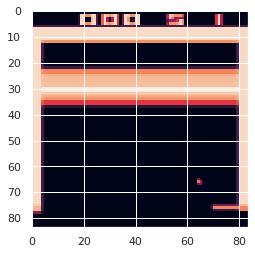

TARGET D1:


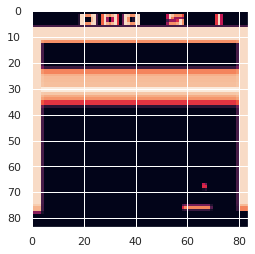

PRED D1:


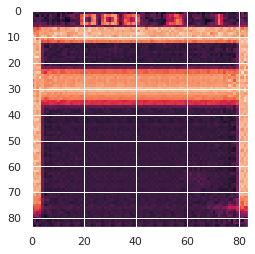

TARGET D2:


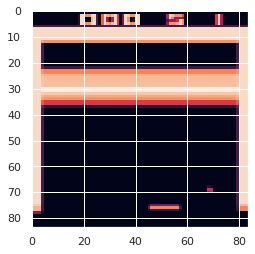

PRED D2:


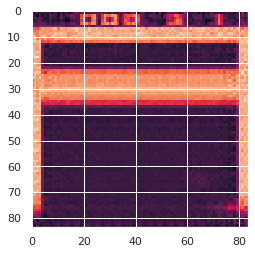

Batch 1, loss_ae_1 0.0006671377923339605, loss_ae_2 0.0007041181670501828
Batch 2, loss_ae_1 0.0004839625325985253, loss_ae_2 0.0005192753742448986
Batch 3, loss_ae_1 0.00039406586438417435, loss_ae_2 0.00042860727990046144
Batch 4, loss_ae_1 0.000394281029002741, loss_ae_2 0.0004425863444339484
Batch 5, loss_ae_1 0.0003641796938609332, loss_ae_2 0.00041148511809296906
OBS:


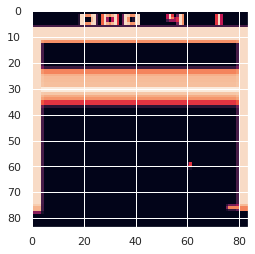

TARGET D1:


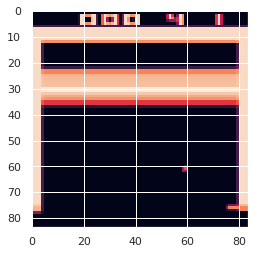

PRED D1:


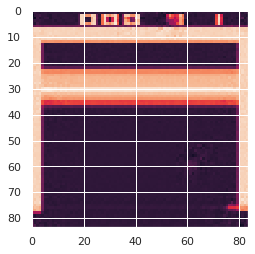

TARGET D2:


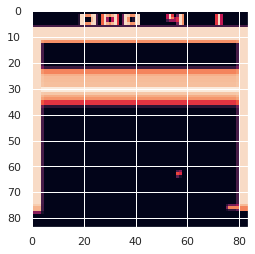

PRED D2:


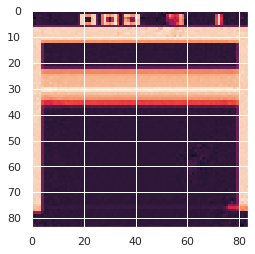

Batch 6, loss_ae_1 0.0003252656024415046, loss_ae_2 0.00036932245711795986
Batch 7, loss_ae_1 0.00030772952595725656, loss_ae_2 0.0003488809452392161
Batch 8, loss_ae_1 0.00029494590125977993, loss_ae_2 0.00034049840178340673
Batch 9, loss_ae_1 0.0003010255750268698, loss_ae_2 0.0003444163012318313
Batch 10, loss_ae_1 0.00027574365958571434, loss_ae_2 0.00031881462200544775
OBS:


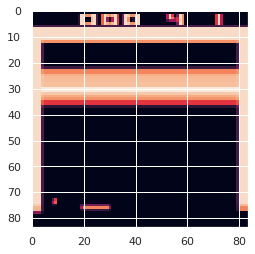

TARGET D1:


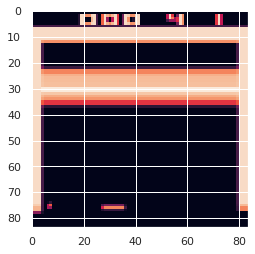

PRED D1:


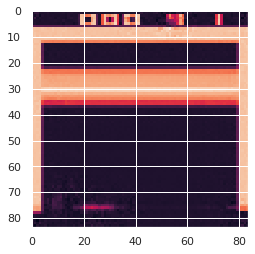

TARGET D2:


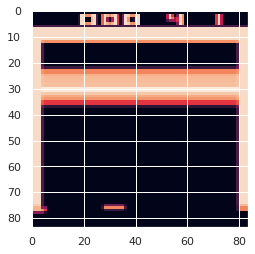

PRED D2:


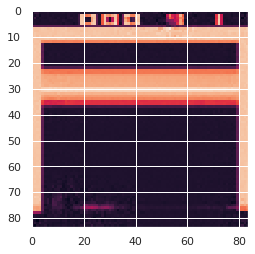

Batch 11, loss_ae_1 0.0002566400507930666, loss_ae_2 0.00030616106232628226
Batch 12, loss_ae_1 0.00023765210062265396, loss_ae_2 0.0003333410422783345
Batch 13, loss_ae_1 0.0002564906026236713, loss_ae_2 0.0003058798611164093
Batch 14, loss_ae_1 0.000283779576420784, loss_ae_2 0.00031256896909326315
Batch 15, loss_ae_1 0.0002544499293435365, loss_ae_2 0.0003630247083492577
OBS:


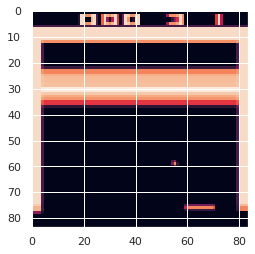

TARGET D1:


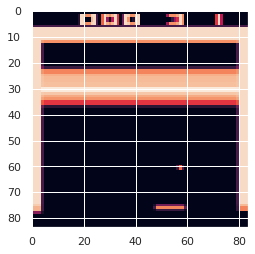

PRED D1:


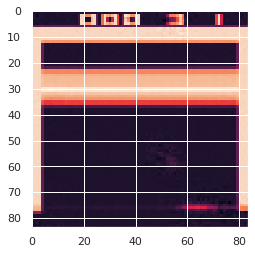

TARGET D2:


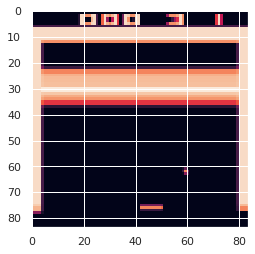

PRED D2:


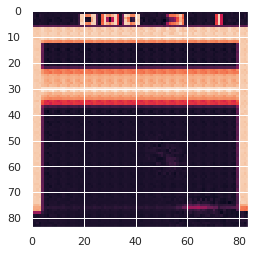

Batch 16, loss_ae_1 0.0002161152515327558, loss_ae_2 0.0003034211113117635
Batch 17, loss_ae_1 0.00023690919624641538, loss_ae_2 0.0003032824315596372
Batch 18, loss_ae_1 0.0002648351073730737, loss_ae_2 0.0003281279932707548
Batch 19, loss_ae_1 0.00020653467800002545, loss_ae_2 0.0002511086640879512
Batch 20, loss_ae_1 0.0002483382122591138, loss_ae_2 0.00031851703533902764
OBS:


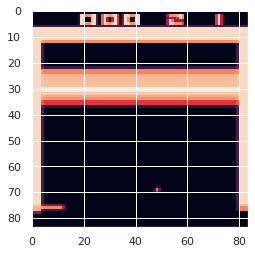

TARGET D1:


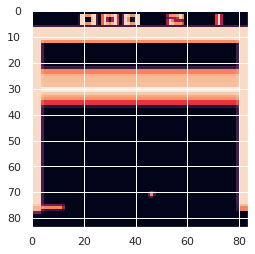

PRED D1:


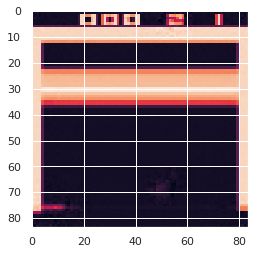

TARGET D2:


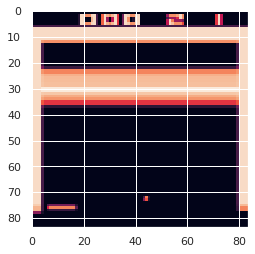

PRED D2:


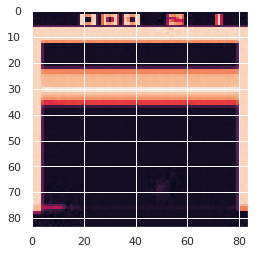

Batch 21, loss_ae_1 0.00019779021386057138, loss_ae_2 0.0002398685901425779
Batch 22, loss_ae_1 0.00020274907001294196, loss_ae_2 0.00024935058900155127
Batch 23, loss_ae_1 0.00021314850891940296, loss_ae_2 0.0002736721944529563
Batch 24, loss_ae_1 0.00020455534104257822, loss_ae_2 0.00025249869213439524
Batch 25, loss_ae_1 0.0002273540012538433, loss_ae_2 0.0002526533498894423
OBS:


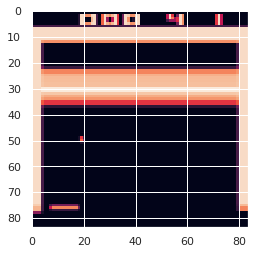

TARGET D1:


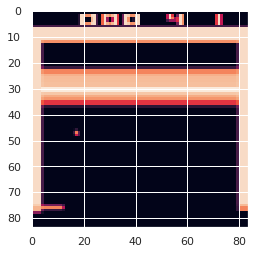

PRED D1:


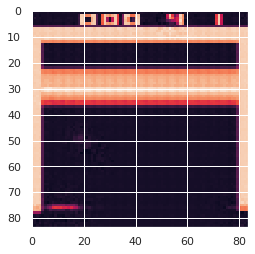

TARGET D2:


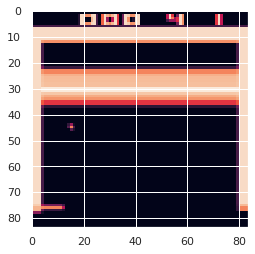

PRED D2:


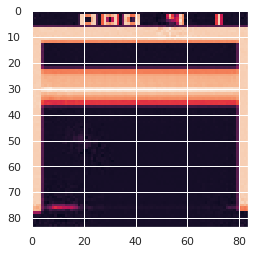

Batch 26, loss_ae_1 0.0002544343296904117, loss_ae_2 0.00028675945941358805
Batch 27, loss_ae_1 0.00019823470211122185, loss_ae_2 0.0002462657284922898
Batch 28, loss_ae_1 0.00022392386745195836, loss_ae_2 0.00026880536461248994
Batch 29, loss_ae_1 0.0002303066721651703, loss_ae_2 0.0002809164288919419
Batch 30, loss_ae_1 0.0002028281887760386, loss_ae_2 0.00025361013831570745
OBS:


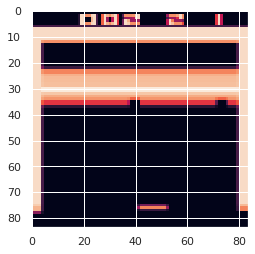

TARGET D1:


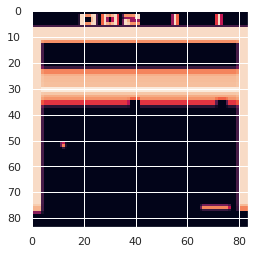

PRED D1:


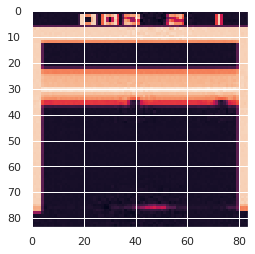

TARGET D2:


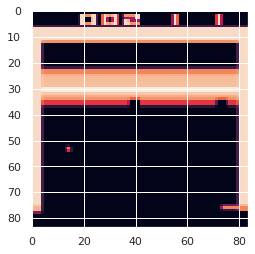

PRED D2:


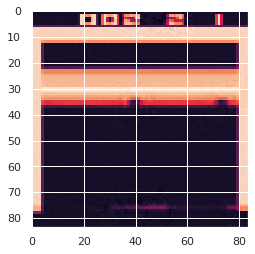

Batch 31, loss_ae_1 0.0001811299443943426, loss_ae_2 0.00022791078663431108
Batch 32, loss_ae_1 0.0002120516001014039, loss_ae_2 0.00024067166668828577
Batch 33, loss_ae_1 0.00019084363884758204, loss_ae_2 0.000238784501561895
Batch 34, loss_ae_1 0.0002080058038700372, loss_ae_2 0.00024206297530326992
Batch 35, loss_ae_1 0.00019997013441752642, loss_ae_2 0.00027641127235256135
OBS:


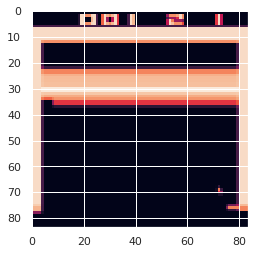

TARGET D1:


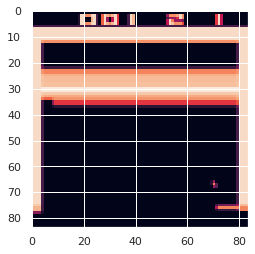

PRED D1:


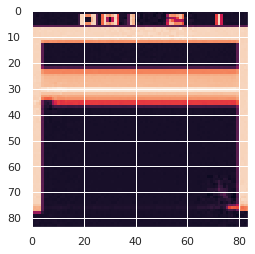

TARGET D2:


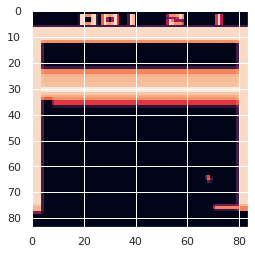

PRED D2:


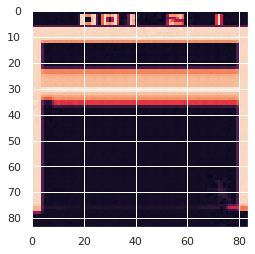

Batch 36, loss_ae_1 0.00018750906747300178, loss_ae_2 0.0002386300911894068
Batch 37, loss_ae_1 0.0001659136323723942, loss_ae_2 0.00024167376977857202
Batch 38, loss_ae_1 0.0001589004968991503, loss_ae_2 0.00020044650591444224
Batch 39, loss_ae_1 0.00018648906552698463, loss_ae_2 0.00023593926744069904
Batch 40, loss_ae_1 0.0002059203980024904, loss_ae_2 0.0002534157829359174
OBS:


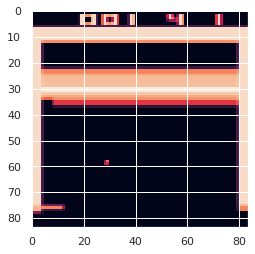

TARGET D1:


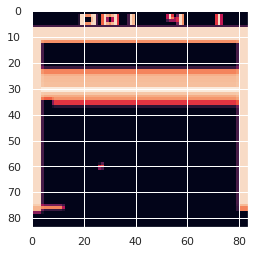

PRED D1:


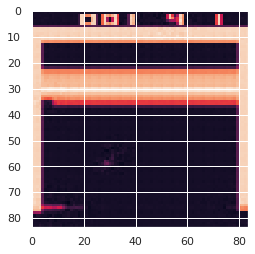

TARGET D2:


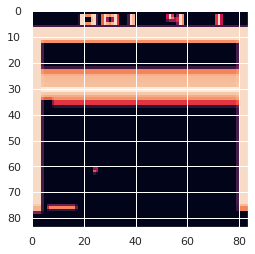

PRED D2:


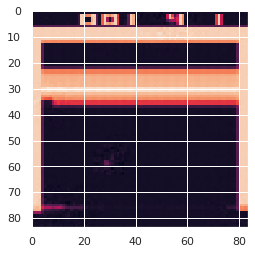

Batch 41, loss_ae_1 0.00019291401258669794, loss_ae_2 0.00024158012820407748
Batch 42, loss_ae_1 0.0001931520673679188, loss_ae_2 0.00022379409347195178
Batch 43, loss_ae_1 0.00019343446183484048, loss_ae_2 0.0002476240915711969
Batch 44, loss_ae_1 0.00018393613572698087, loss_ae_2 0.00023201768635772169
Batch 45, loss_ae_1 0.0001955943153006956, loss_ae_2 0.00027431390481069684
OBS:


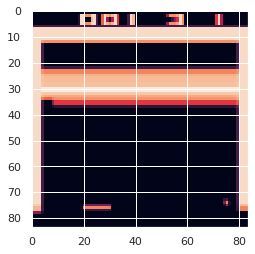

TARGET D1:


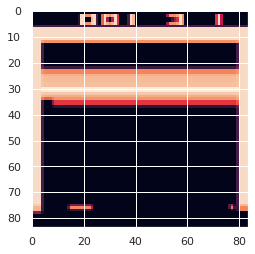

PRED D1:


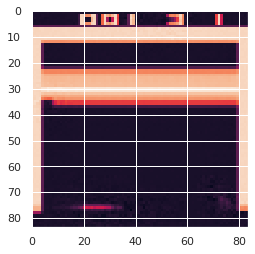

TARGET D2:


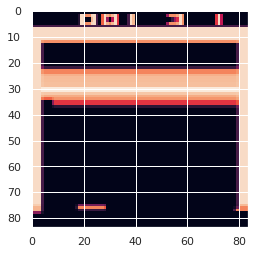

PRED D2:


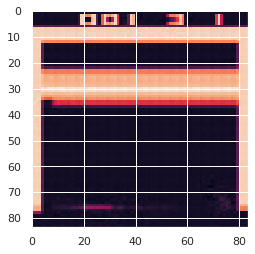

Batch 46, loss_ae_1 0.00018888365593738854, loss_ae_2 0.0002316790632903576
Batch 47, loss_ae_1 0.0001661729475017637, loss_ae_2 0.0002189106890000403
Batch 48, loss_ae_1 0.00019451302068773657, loss_ae_2 0.0002475306682754308
Batch 49, loss_ae_1 0.000175047418451868, loss_ae_2 0.0002192123356508091
Batch 50, loss_ae_1 0.00018505055049899966, loss_ae_2 0.0002222946786787361
OBS:


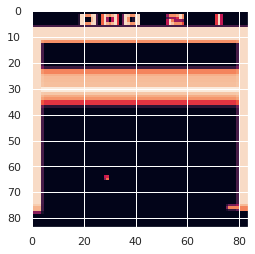

TARGET D1:


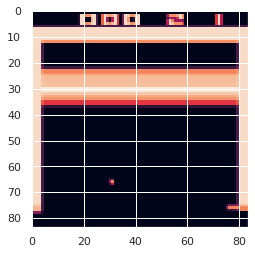

PRED D1:


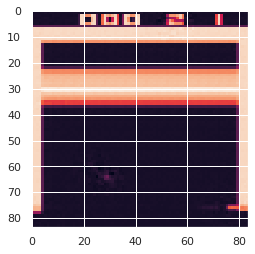

TARGET D2:


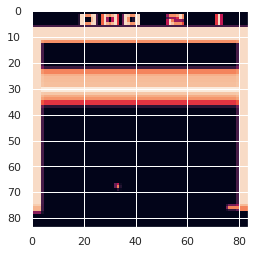

PRED D2:


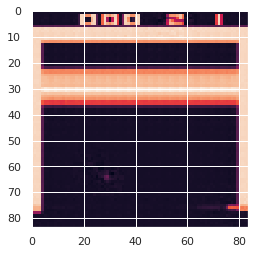

Batch 51, loss_ae_1 0.00015824250294826925, loss_ae_2 0.00019872789562214166
Batch 52, loss_ae_1 0.00018158843158744276, loss_ae_2 0.0002300140040460974
Batch 53, loss_ae_1 0.00018721788364928216, loss_ae_2 0.00021959160221740603
Batch 54, loss_ae_1 0.0001658838300500065, loss_ae_2 0.00021813945204485208
Batch 55, loss_ae_1 0.00018550880486145616, loss_ae_2 0.00024957701680250466
OBS:


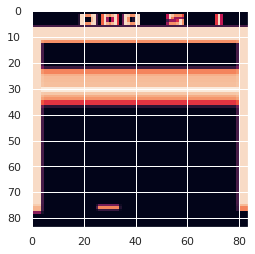

TARGET D1:


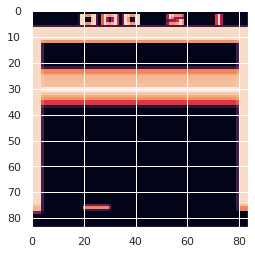

PRED D1:


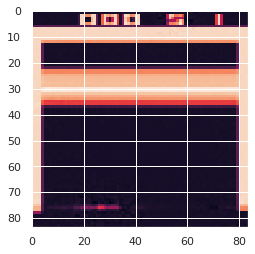

TARGET D2:


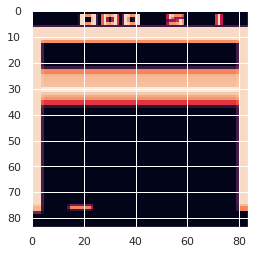

PRED D2:


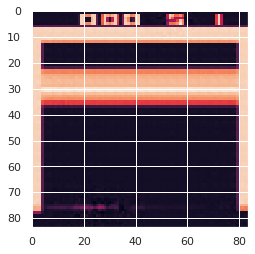

Batch 56, loss_ae_1 0.0001900915667647496, loss_ae_2 0.0002381587983109057
Batch 57, loss_ae_1 0.00020641244191210717, loss_ae_2 0.00023627532937098294
Batch 58, loss_ae_1 0.00018936365086119622, loss_ae_2 0.00022000655008014292
Batch 59, loss_ae_1 0.00017935680807568133, loss_ae_2 0.00023203172895591706
Batch 60, loss_ae_1 0.00017528199532534927, loss_ae_2 0.00023297258303500712
OBS:


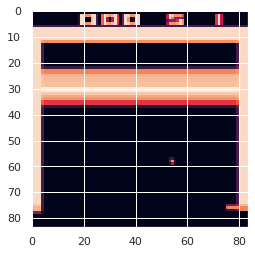

TARGET D1:


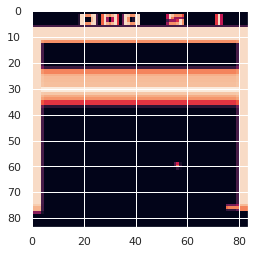

PRED D1:


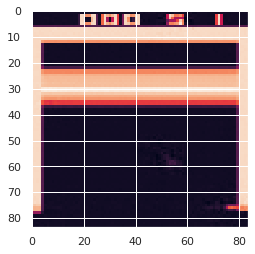

TARGET D2:


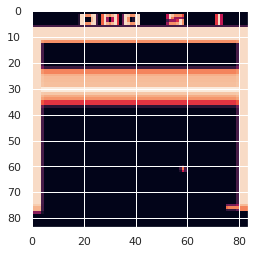

PRED D2:


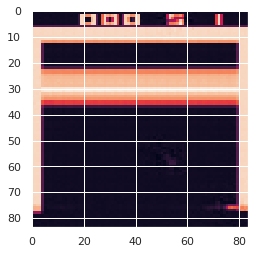

Batch 61, loss_ae_1 0.0001482688239775598, loss_ae_2 0.00020187822519801557
Batch 62, loss_ae_1 0.000173623047885485, loss_ae_2 0.00021687113621737808
Batch 63, loss_ae_1 0.000168096405104734, loss_ae_2 0.00021018179540988058
Batch 64, loss_ae_1 0.00015633313159924, loss_ae_2 0.00020105953444726765
Batch 65, loss_ae_1 0.00019579261424951255, loss_ae_2 0.00020452251192182302
OBS:


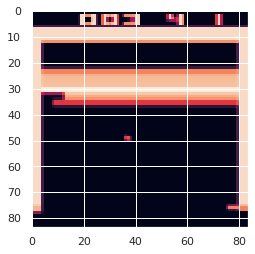

TARGET D1:


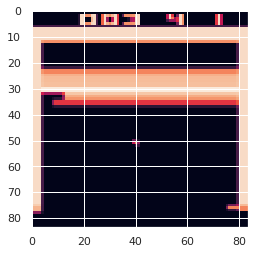

PRED D1:


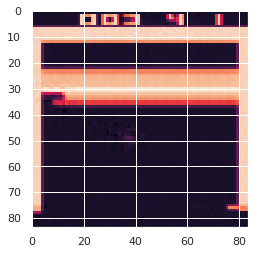

TARGET D2:


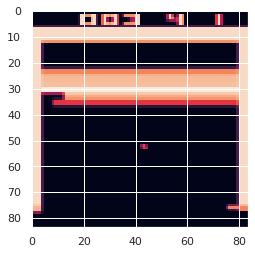

PRED D2:


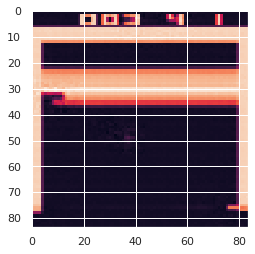

Batch 66, loss_ae_1 0.00014982833818066865, loss_ae_2 0.00018497671408113092
Batch 67, loss_ae_1 0.0001764460903359577, loss_ae_2 0.00022681754489894956
Batch 68, loss_ae_1 0.0002062581042991951, loss_ae_2 0.00022431675461120903
Batch 69, loss_ae_1 0.00014589977217838168, loss_ae_2 0.00018888237536884844
Batch 70, loss_ae_1 0.00015915086260065436, loss_ae_2 0.00020439858781173825
OBS:


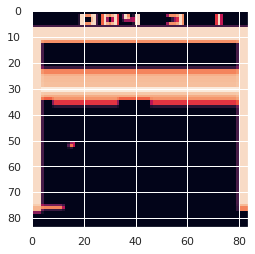

TARGET D1:


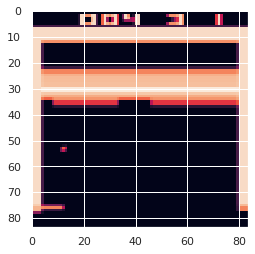

PRED D1:


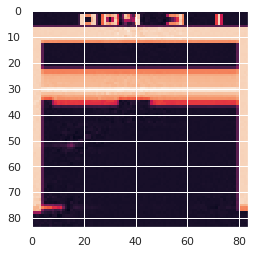

TARGET D2:


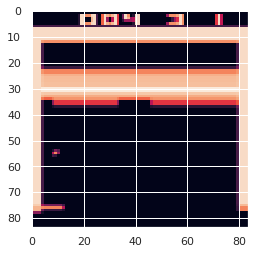

PRED D2:


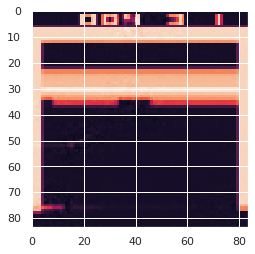

Batch 71, loss_ae_1 0.00018023207667283714, loss_ae_2 0.0002401304227532819
Batch 72, loss_ae_1 0.0001539015065645799, loss_ae_2 0.00019654705829452723
Batch 73, loss_ae_1 0.00016088102711364627, loss_ae_2 0.00021008022304158658
Batch 74, loss_ae_1 0.00017308884707745165, loss_ae_2 0.00022974013700149953
Batch 75, loss_ae_1 0.0001446390087949112, loss_ae_2 0.00018276406626682729
OBS:


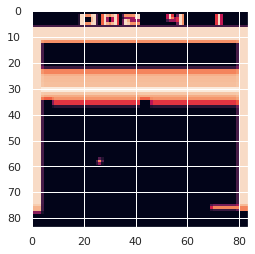

TARGET D1:


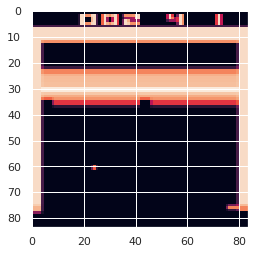

PRED D1:


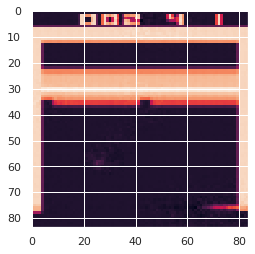

TARGET D2:


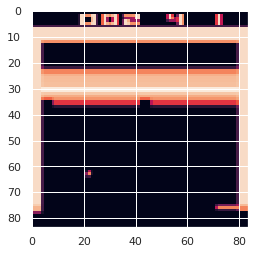

PRED D2:


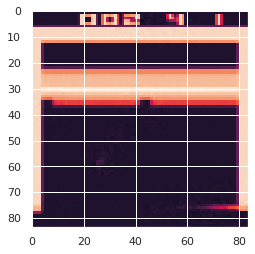

Batch 76, loss_ae_1 0.00014655730046797544, loss_ae_2 0.00022162662935443223
Batch 77, loss_ae_1 0.0001514754694653675, loss_ae_2 0.00019754566892515868
Batch 78, loss_ae_1 0.0001595890207681805, loss_ae_2 0.000209038145840168
Batch 79, loss_ae_1 0.00017109922191593796, loss_ae_2 0.00018919449939858168
Batch 80, loss_ae_1 0.00017133509390987456, loss_ae_2 0.00019575438636820763
OBS:


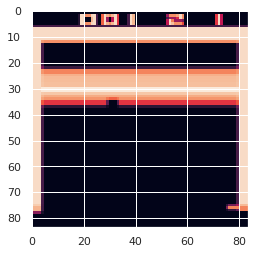

TARGET D1:


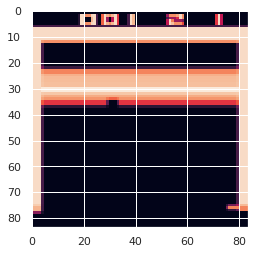

PRED D1:


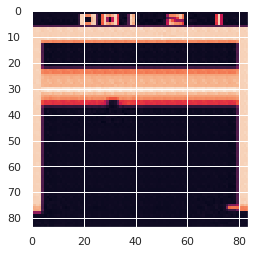

TARGET D2:


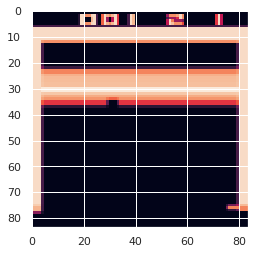

PRED D2:


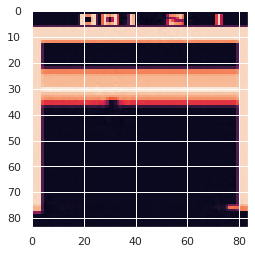

Batch 81, loss_ae_1 0.00016166770365089178, loss_ae_2 0.00021262919472064823
Batch 82, loss_ae_1 0.0001564880076330155, loss_ae_2 0.00020087332814000547
Batch 83, loss_ae_1 0.00016419835446868092, loss_ae_2 0.00022234440257307142
Batch 84, loss_ae_1 0.00015828486357349902, loss_ae_2 0.00020906847203150392
Batch 85, loss_ae_1 0.0001755738048814237, loss_ae_2 0.00021069082140456885
OBS:


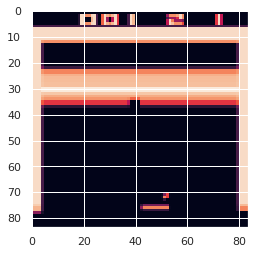

TARGET D1:


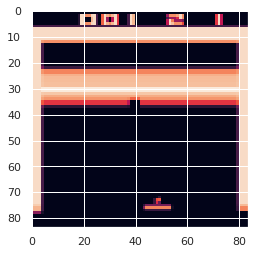

PRED D1:


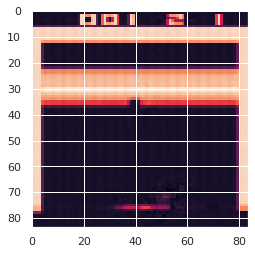

TARGET D2:


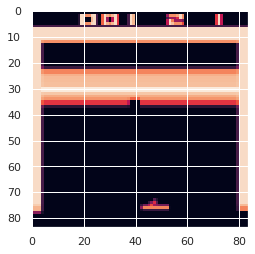

PRED D2:


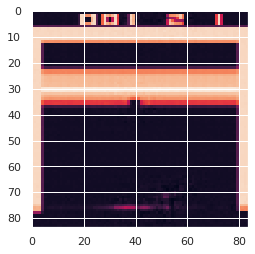

Batch 86, loss_ae_1 0.00013401861360762268, loss_ae_2 0.00017476201173849404
Batch 87, loss_ae_1 0.00014393309538718313, loss_ae_2 0.00019442246411927044
Batch 88, loss_ae_1 0.0001622758572921157, loss_ae_2 0.00021484048920683563
Batch 89, loss_ae_1 0.00013872780255042017, loss_ae_2 0.0001843007921706885
Batch 90, loss_ae_1 0.00015390731277875602, loss_ae_2 0.00020189538190606982
OBS:


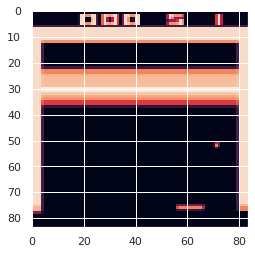

TARGET D1:


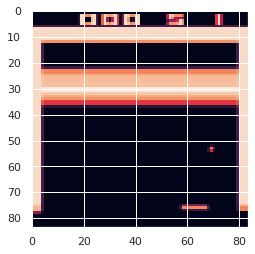

PRED D1:


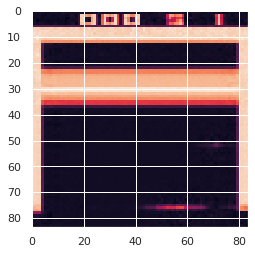

TARGET D2:


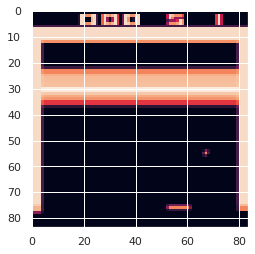

PRED D2:


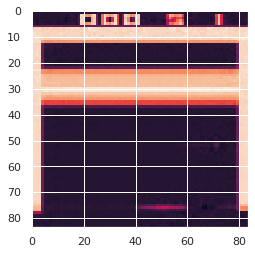

Batch 91, loss_ae_1 0.00014661127352155745, loss_ae_2 0.00019456706650089473
Batch 92, loss_ae_1 0.00016037499881349504, loss_ae_2 0.00023954639618750662
Batch 93, loss_ae_1 0.00013035998563282192, loss_ae_2 0.00017465448763687164
Batch 94, loss_ae_1 0.00012794655049219728, loss_ae_2 0.0001808428205549717
Batch 95, loss_ae_1 0.00015784948482178152, loss_ae_2 0.00021199436741881073
OBS:


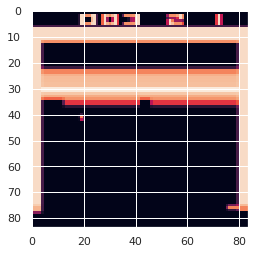

TARGET D1:


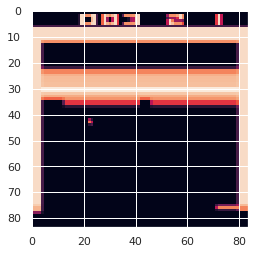

PRED D1:


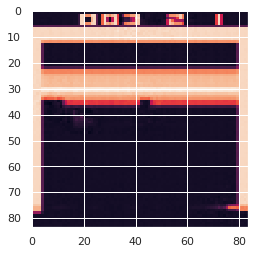

TARGET D2:


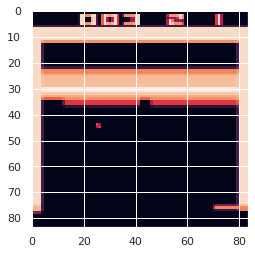

PRED D2:


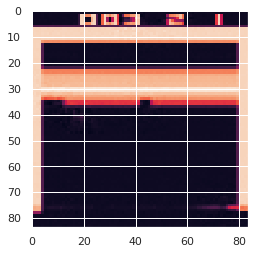

Batch 96, loss_ae_1 0.00012906610209029168, loss_ae_2 0.00017726483929436654
Batch 97, loss_ae_1 0.00012937517021782696, loss_ae_2 0.00017937617667485029
Batch 98, loss_ae_1 0.00014533453213516623, loss_ae_2 0.00018497556447982788
Batch 99, loss_ae_1 0.0001354325213469565, loss_ae_2 0.00018274803005624563
Batch 100, loss_ae_1 0.00016821267490740865, loss_ae_2 0.00021588469098787755
OBS:


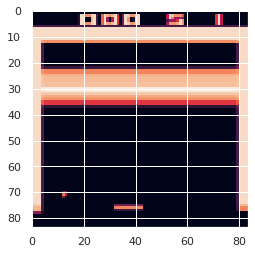

TARGET D1:


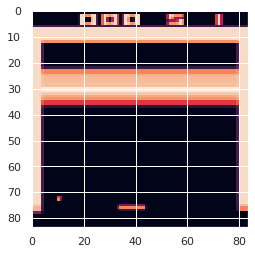

PRED D1:


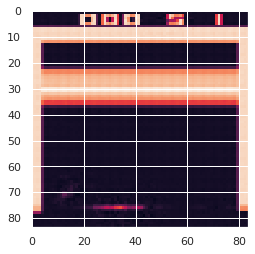

TARGET D2:


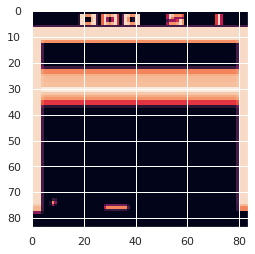

PRED D2:


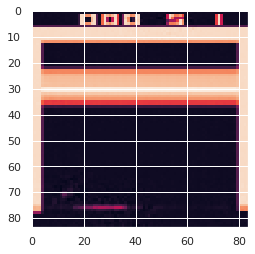

Batch 101, loss_ae_1 0.00014406770060304552, loss_ae_2 0.0002144485479220748


KeyboardInterrupt: ignored

In [0]:
FR = ROLLOUT_LENGTH*NENV

loss_history_ae_1 = []
loss_history_ae_2 = []
frames_loss_history_ae_1 = []
frames_loss_history_ae_2 = []

# Testing AE / pretraining
for ii in range(NUM_UPDATES):
    obs, obs_d1, obs_d2, logps, actions, values, rewards, infos = next(rgen)
    obs_d1 = obs_d1[:,-1,:,:].unsqueeze(1)
    obs_d2 = obs_d2[:,-1,:,:].unsqueeze(1)
    for jj in range(100):
        pred_ae_1, z1 = ae_delta_1(obs, actions.cpu().numpy().astype(int))
        citerion  = nn.MSELoss()
        loss_ae_1 = citerion(pred_ae_1, obs_d1)
        ae_optim_1.zero_grad()
        loss_ae_1.backward()
        nn.utils.clip_grad_norm_(ae_delta_1.parameters(), 0.5)
        ae_optim_1.step()

        pred_ae_2, z2 = ae_delta_2(obs, actions.cpu().numpy().astype(int))
        citerion  = nn.MSELoss()
        loss_ae_2 = citerion(pred_ae_2, obs_d2)
        ae_optim_2.zero_grad()
        loss_ae_2.backward()
        nn.utils.clip_grad_norm_(ae_delta_2.parameters(), 0.5)
        ae_optim_2.step()

        frames = (ii*100*FR) + (jj*FR)
        loss_history_ae_1.append(loss_ae_1.item())
        frames_loss_history_ae_1.append((frames, loss_ae_1.item()))
        loss_history_ae_2.append(loss_ae_2.item())
        frames_loss_history_ae_2.append((frames, loss_ae_2.item()))
        
    print(f'Batch {ii}, loss_ae_1 {loss_ae_1}, loss_ae_2 {loss_ae_2}')
    ae_1_scheduler.step(ii)
    ae_2_scheduler.step(ii)

    if ii % 5 == 0:
        print('OBS:')
        plt.imshow(obs.cpu().numpy()[500][-1])
        plt.show()
        print('TARGET D1:')
        plt.imshow(obs_d1.cpu().numpy()[500][-1])
        plt.show()
        print('PRED D1:')
        plt.imshow(pred_ae_1.detach().cpu().numpy()[500][-1])
        plt.show()
        print('TARGET D2:')
        plt.imshow(obs_d2.cpu().numpy()[500][-1])
        plt.show()
        print('PRED D2:')
        plt.imshow(pred_ae_2.detach().cpu().numpy()[500][-1])
        plt.show()

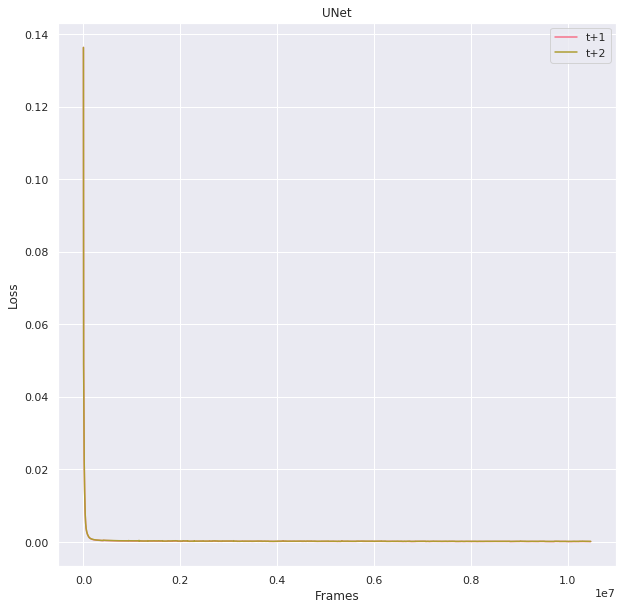

In [0]:
fig, ax = plt.subplots(figsize=(10,10))
ax.set_xlabel('Frames')
ax.set_ylabel('Loss')
ax.set_title('UNet')
clrs = sns.color_palette("husl", 5)

ax.plot(
    *zip(*frames_loss_history_ae_1),
    label='t+1', 
    c=clrs[0]
)
ax.plot(
    *zip(*frames_loss_history_ae_2),
    label='t+2', 
    c=clrs[1]
)

ax.legend(loc='upper right')

In [0]:
T.save(ae_delta_1.state_dict(), 'ae1-unet-breakout-64-1frame-ALLactionin.torch')
T.save(ae_delta_2.state_dict(), 'ae2-unet-breakout-64-1frame-ALLactionin.torch')

In [0]:
from google.colab import files

files.download('ae1-unet-breakout-64-1frame-ALLactionin.torch')
# files.download('ae2-unet-breakout.torch')

In [0]:
import gym

e2 = gym.make(ENV_NAME)
e2.unwrapped.get_action_meanings()

['NOOP', 'FIRE', 'RIGHT', 'LEFT']

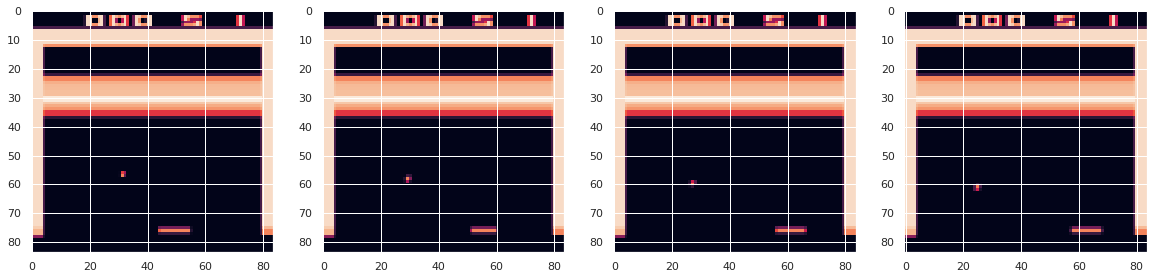

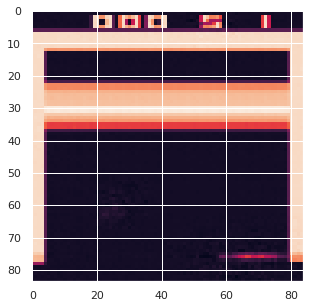

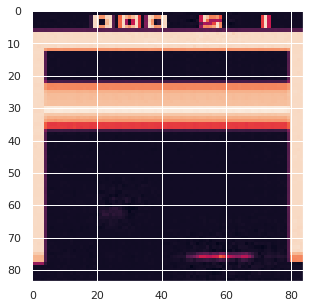

Should have left bais


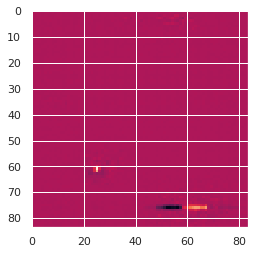

Should have right bais


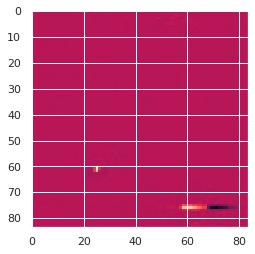

In [0]:
# Lets see whether our model has learned a self model

test_ob = obs[480]

fig, axs = plt.subplots(1, 4, figsize=(20,20))
im_ob = test_ob.cpu().numpy()
[a.imshow(im_ob[i]) for i, a in enumerate(axs)]
plt.show()

# # the paddle should stay stationary after taking action 0
# pred_tb, z_tb = ae_delta_2(test_ob.unsqueeze(0), [0])
# im_tb = pred_tb.detach().cpu().numpy()[0]
# fig, axs = plt.subplots(1, 4, figsize=(20,20))
# [a.imshow(im_tb[i]) for i, a in enumerate(axs)]
# plt.show()

# # the paddle should stay stationary after taking action 1
# pred_tb, z_tb = ae_delta_2(test_ob.unsqueeze(0), [1])
# im_tb = pred_tb.detach().cpu().numpy()[0]
# fig, axs = plt.subplots(1, 4, figsize=(20,20))
# [a.imshow(im_tb[i]) for i, a in enumerate(axs)]
# plt.show()

# the paddle should be a bit to the right after taking action 2
pred_tb, z_tb = ae_delta_1(test_ob.unsqueeze(0), [2])
im_tb = pred_tb.detach().cpu().numpy()[0]
fig, axs = plt.subplots(1, 1, figsize=(5,5))
axs.imshow(im_tb[0])
plt.show()

# the paddle should be a bit to the left after taking action 3
pred_ta, z_ta = ae_delta_1(test_ob.unsqueeze(0), [3])
im_ta = pred_ta.detach().cpu().numpy()[0]
fig, axs = plt.subplots(1, 1, figsize=(5,5))
axs.imshow(im_ta[0])
plt.show()


print('Should have left bais')
plt.imshow((im_ob-im_ta)[-1])
plt.show()

print('Should have right bais')
plt.imshow((im_ob-im_tb)[-1])
plt.show()


In [0]:
# this worked a little!

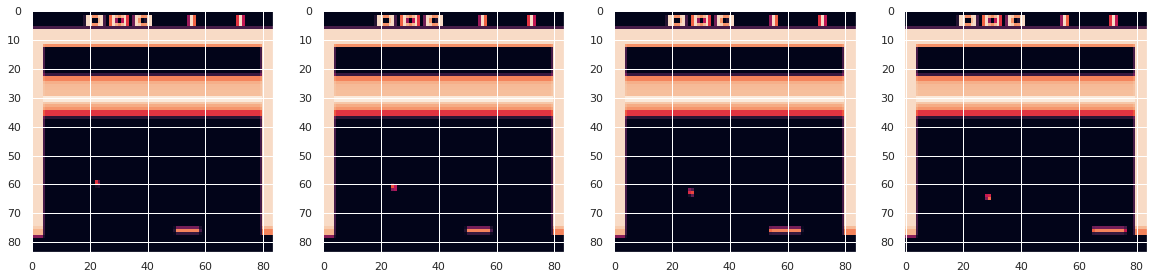

In [0]:
obz,_,_,_ = env.step([2]*8)
im_ob = obz[4]/255.

fig, axs = plt.subplots(1, 4, figsize=(20,20))
[a.imshow(im_ob[:,:,i]) for i, a in enumerate(axs)]
plt.show()